In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%config Completer.use_jedi = False

# 먼저 ImageDataGenerator를 이용하여 예제 이미지에 Augmentation 적용하기
* ImageDataGenerator는 fit(), flow()를 통해서 입력된 image array(numpy)를 변환시킬 수 있으며, 실제 변환은 next()를 통해 iteration 호출을 해야한다.
* ImageDataGenerator가 입력으로 받는 image array는 batch를 포함한 4차원 array이다. 따라서 단일 이미지를 돌리는 경우 차원 확장을 통해서 batch 반영을 해줘야 한다.
* 변경된 픽셀 값은 float이므로 numpy imshow로 이미지를 보기 위해선 int형으로 변환이 필요.

In [3]:
# sample image
!wget https://www.sciencenews.org/wp-content/uploads/2020/03/033120_HT_covid-cat_feat-1028x579.jpg

--2024-02-13 14:21:54--  https://www.sciencenews.org/wp-content/uploads/2020/03/033120_HT_covid-cat_feat-1028x579.jpg
Resolving www.sciencenews.org (www.sciencenews.org)... 52.84.18.47, 52.84.18.121, 52.84.18.25, ...
Connecting to www.sciencenews.org (www.sciencenews.org)|52.84.18.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61745 (60K) [image/jpeg]
Saving to: '033120_HT_covid-cat_feat-1028x579.jpg'

033120_HT_covid-cat 100%[===================>]  60.30K  --.-KB/s    in 0.01s   

2024-02-13 14:21:54 (4.46 MB/s) - '033120_HT_covid-cat_feat-1028x579.jpg' saved [61745/61745]



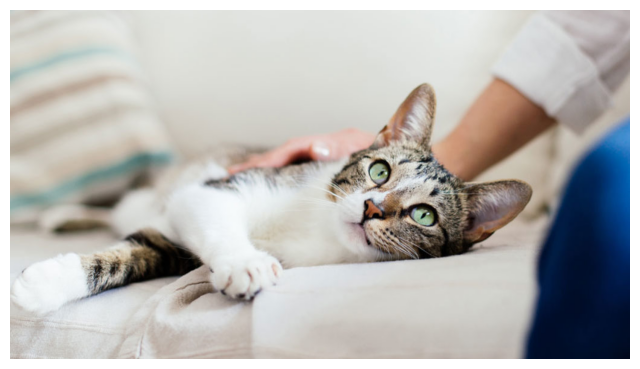

In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# cv2.imread를 통해 이미지 파일을 numpy array로 올린다.
# 또한 imread의 경우 이미지가 BGR 순서로 나오므로 이를 RGB 순서로 바꿔주는 작업이 필요하다.
image = cv2.cvtColor(cv2.imread('033120_HT_covid-cat_feat-1028x579.jpg'), cv2.COLOR_BGR2RGB)

def show_image(image):
    plt.figure(figsize=(8,8))
    plt.imshow(image)
    plt.axis('off')
    
show_image(image)

## 좌우 반전(Horizontal Flip) 적용을 통한 예시
* 모든 효과는 모두 일괄적으로 적용되는 것은 아니고 랜덤하게 적용 여부가 결정된다.
* horizontal_flip=True를 통해 좌우 반전 적용. 

2024-02-13 14:21:57.614704: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 14:21:57.614833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 14:21:57.777147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


image_batch shape: (1, 579, 1028, 3)
aug_image shape: (579, 1028, 3)


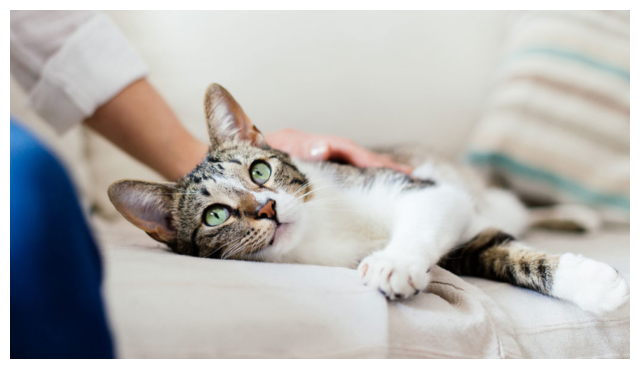

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# horizontal flip 적용. 그러나 무조건적으로 적용되는 것은 아니다.
data_generator = ImageDataGenerator(horizontal_flip=True)

# ImageDataGenerator는 여러개의 image를 입력으로 받기에, batch까지 고려된 4차원 이미지를 넘겨줘야 한다.
image_batch = np.expand_dims(image, axis=0)
print('image_batch shape:', image_batch.shape)

# ImageDataGenerator 적용. fit()후 flow()로 image batch를 넣어주어야 한다.
# 이 단계에선 아직 이미지가 실제로 적용되는 단계는 아니다. 적용을 위한 준비.
data_generator.fit(image_batch)
data_gen_iter = data_generator.flow(image_batch)

# ImageDataGenerator를 동작하기 위해선 next() 등으로 iteration을 호출해야 한다.
aug_image_batch = next(data_gen_iter)

# 변화된 데이터는 batch를 포함한 4차원 array이다.
aug_image = np.squeeze(aug_image_batch)
print('aug_image shape:', aug_image.shape)

# 변환된 pixel값은 float이다. 이를 다시 int형으로 바꾼 후 이미지 시각화 진행.
aug_image = aug_image.astype('int')
show_image(aug_image)

### 여러 ImageDataGenerator 변환을 수행하는 함수 생성
* ImageDataGenerator는 next() 호출이 있을 때마다 random하게 augmentation이 적용되어 반환된다.

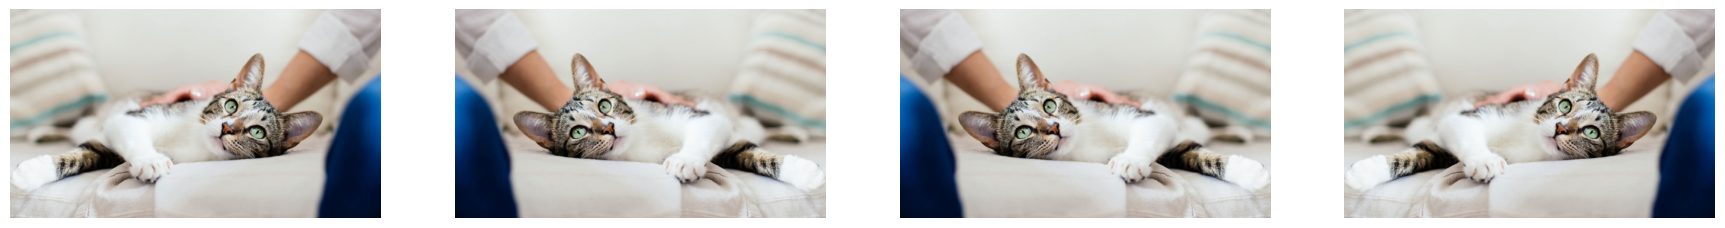

In [6]:
N_IMAGES = 4  # 하나의 이미지에 대해서 4번 반환
fig, axs = plt.subplots(nrows=1, ncols=N_IMAGES, figsize=(22,8))

for i in range(N_IMAGES):
    aug_image_batch = next(data_gen_iter)
    aug_image = np.squeeze(aug_image_batch)
    aug_image = aug_image.astype('int')
    axs[i].imshow(aug_image)
    axs[i].axis('off')

In [7]:
# 위 코드를 함수로 정리한 형태

def show_aug_image_batch(image, data_generator, n_images=4, to_int=True):
    
    image_batch = np.expand_dims(image, axis=0)
    # ImageDataGenerator 적용. fit() 후 flow()로 image batch를 넣어줘야 한다.
    data_generator.fit(image_batch)
    data_gen_iter = data_generator.flow(image_batch)
    
    fig, axs = plt.subplots(nrows=1, ncols=n_images, figsize=(6*n_images, 8))
    
    for i in range(n_images):
        aug_image_batch = next(data_gen_iter)
        aug_image = np.squeeze(aug_image_batch)
        if to_int:
            aug_image = aug_image.astype('int')
        axs[i].imshow(aug_image)
        axs[i].axis('off')

### ImageDataGenerator의 여러 기능들 적용

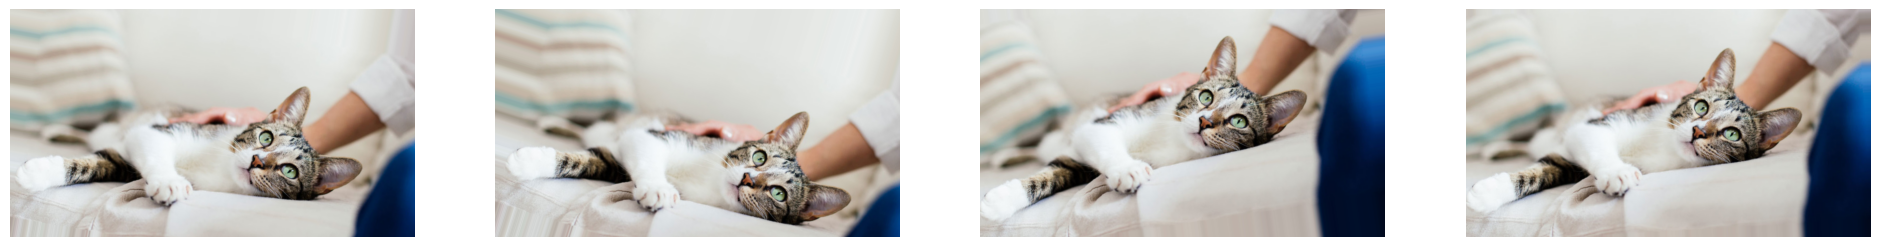

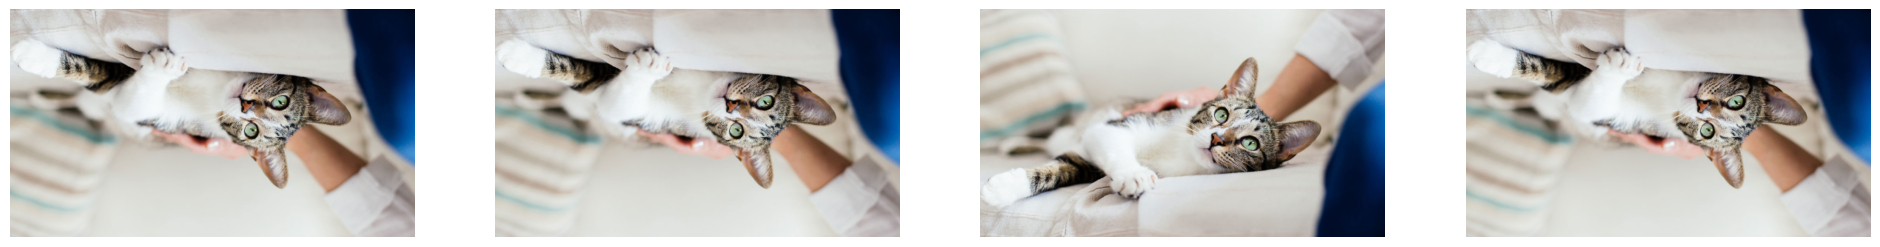

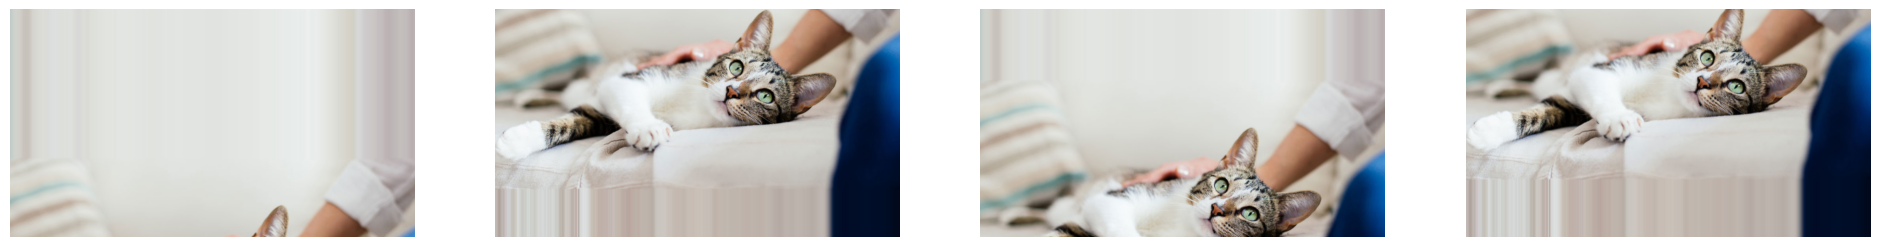

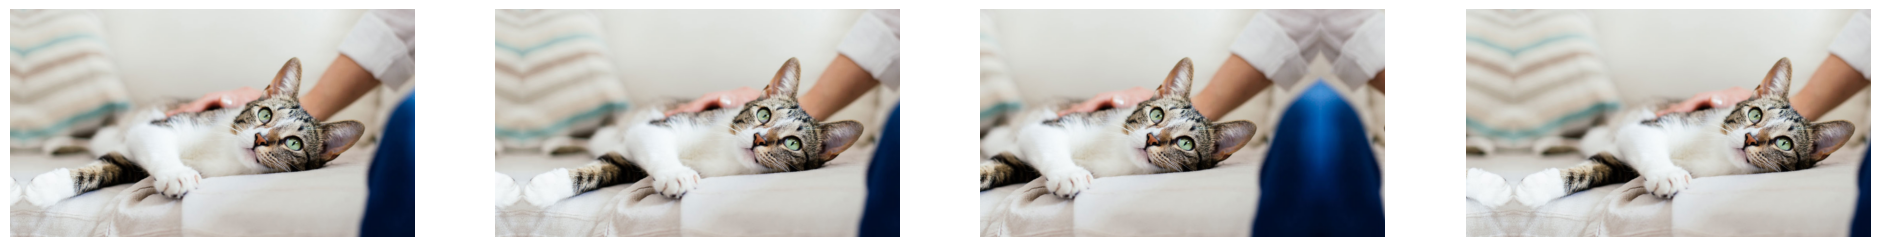

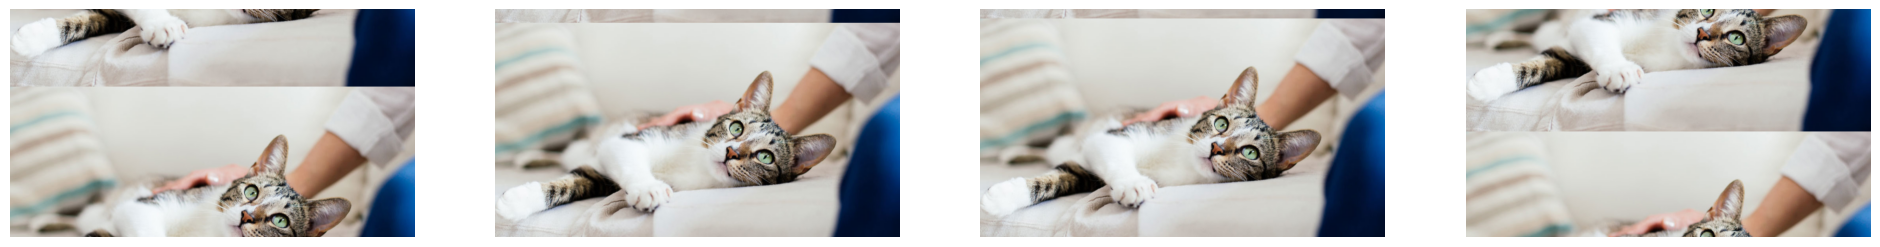

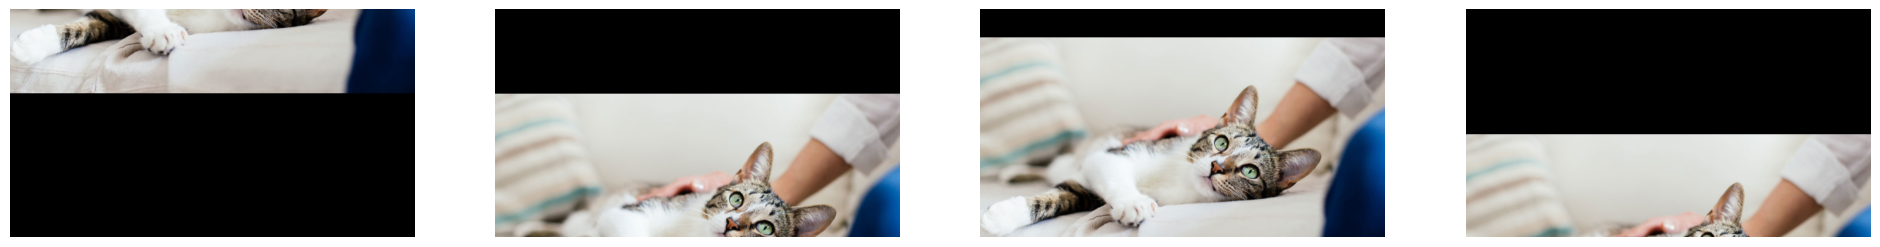

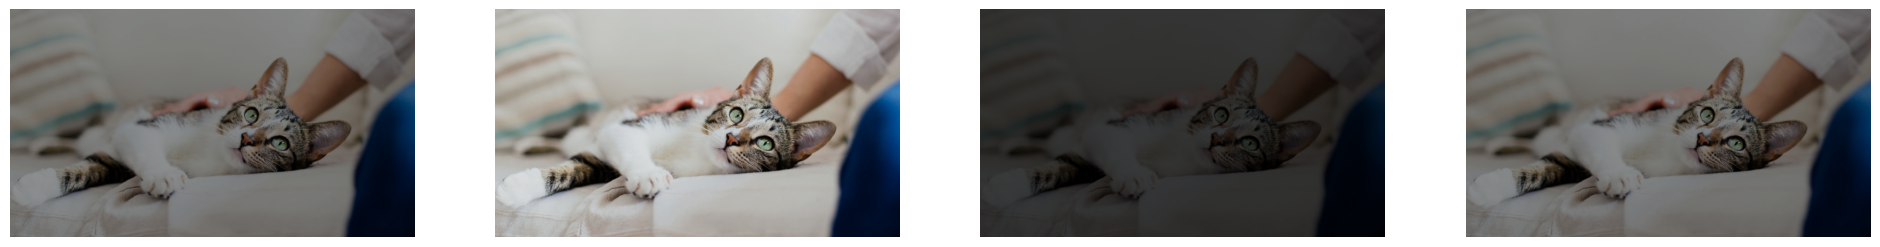

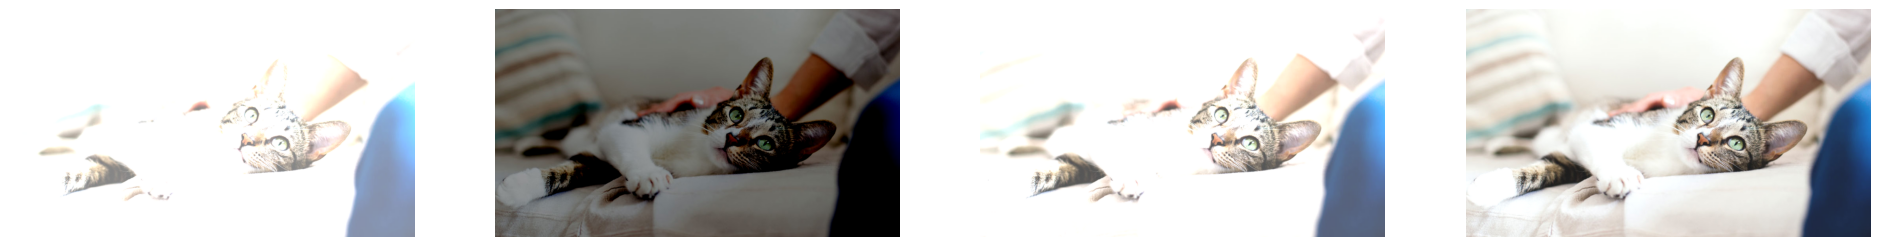

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# rotation 범위는 -45 ~ +45로 설정
data_gen = ImageDataGenerator(rotation_range=45)  # fill nearest로 픽셀을 채운다
show_aug_image_batch(image, data_gen, n_images=4)

# horizontal, vertical flip 동시에 적용
data_gen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
show_aug_image_batch(image, data_gen, n_images=4)

# shift를 통한 이미지 이동
# 이때 이동하면서 남는 공간은 nearest, reflect, wrap, constant 옵션을 통해 채운다.
data_gen = ImageDataGenerator(width_shift_range=0.4, fill_mode='nearest')
show_aug_image_batch(image, data_gen, n_images=4)

data_gen = ImageDataGenerator(height_shift_range=0.4, fill_mode='reflect')
show_aug_image_batch(image, data_gen, n_images=4)

data_gen = ImageDataGenerator(width_shift_range=0.4, fill_mode='wrap')
show_aug_image_batch(image, data_gen, n_images=4)

data_gen = ImageDataGenerator(width_shift_range=0.4, fill_mode='constant', cval=0)
show_aug_image_batch(image, data_gen, n_images=4)

# brightness_range로 0~1 사이 값을 입력해 밝기를 조절한다. 0에 가까우면 어둡고 1에 가까우면 밝아진다.
data_gen = ImageDataGenerator(brightness_range=(0.1, 0.9))
show_aug_image_batch(image,data_gen, n_images=4)

# channel shift 적용
# 원본 이미지의 RGB pixel 값을 channel shift range 범위에 있는 임의의 값으로 변환.
data_gen = ImageDataGenerator(channel_shift_range=150.0)  # -150에서 +150 사이의 값
show_aug_image_batch(image, data_gen, n_images=4)

### Normalization
* 일반적으로 augmentation 용도가 아닌 CNN에 입력된 값으로 pixel값의 변환을 위해 0~1 사이의 값으로 변환하거나 채널별로 z score 변환 적용.
* featurewise_center을 적용하면 RGB 각 픽셀값에서 개별 채널들의 평균 픽셀값을 빼서 평균을 0으로 만든다.
* featurewise_std_normalization을 적용하면 RGB 픽셀값에서 개별 채널들의 표준 편차값으로 나눈다.
* rescale = 255.0은 각 픽셀값을 0~1 사이의 값으로 만들기 위해서 보통 255.0으로 나눈다. 참고로 딥러닝 입력값에 있어선 비교적 작은 값을 선호하는 경향이 있어 이를 맞춰주기 위해서 해당 기능을 사용한다.

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
image_batch = np.expand_dims(image, axis=0)

data_generator.fit(image_batch)
data_gen_iter = data_generator.flow(image_batch)

aug_image_batch = next(data_gen_iter)

aug_image = np.squeeze(aug_image_batch)
print(aug_image)

# 출력해보면 평균 0에 표준편차 1에 근접하다.
print(aug_image.mean())
print(aug_image.std())

[[[ 0.21212701  0.42733452  0.43951732]
  [ 0.22730476  0.4433401   0.4569007 ]
  [ 0.2424825   0.45934564  0.47428405]
  ...
  [ 0.13623834  0.02719526  0.09185016]
  [ 0.13623834  0.02719526  0.09185016]
  [ 0.13623834  0.02719526  0.09185016]]

 [[ 0.22730476  0.4433401   0.4569007 ]
  [ 0.2424825   0.45934564  0.47428405]
  [ 0.25766024  0.4433401   0.47428405]
  ...
  [ 0.13623834  0.02719526  0.09185016]
  [ 0.13623834  0.02719526  0.09185016]
  [ 0.13623834  0.02719526  0.09185016]]

 [[ 0.2424825   0.45934564  0.47428405]
  [ 0.27283797  0.45934564  0.4916674 ]
  [ 0.2880157   0.4753512   0.5090508 ]
  ...
  [ 0.13623834  0.02719526  0.09185016]
  [ 0.13623834  0.02719526  0.09185016]
  [ 0.13623834  0.02719526  0.09185016]]

 ...

 [[ 0.22730476  0.15523982  0.10923351]
  [ 0.27283797  0.20325653  0.1613836 ]
  [ 0.06034966 -0.0528326  -0.09936678]
  ...
  [-2.6716428  -2.677746   -2.533037  ]
  [-2.6716428  -2.677746   -2.533037  ]
  [-2.6716428  -2.677746   -2.533037  ]]

 [

In [10]:
data_generator = ImageDataGenerator(rescale=1/255.0)
image_batch = np.expand_dims(image, axis=0)

data_generator.fit(image_batch)
data_gen_iter = data_generator.flow(image_batch)

aug_image_batch = next(data_gen_iter)

aug_image = np.squeeze(aug_image_batch)
print(aug_image)

[[[0.75294125 0.7960785  0.7803922 ]
  [0.7568628  0.8000001  0.7843138 ]
  [0.7607844  0.80392164 0.78823537]
  ...
  [0.73333335 0.69803923 0.7019608 ]
  [0.73333335 0.69803923 0.7019608 ]
  [0.73333335 0.69803923 0.7019608 ]]

 [[0.7568628  0.8000001  0.7843138 ]
  [0.7607844  0.80392164 0.78823537]
  [0.76470596 0.8000001  0.78823537]
  ...
  [0.73333335 0.69803923 0.7019608 ]
  [0.73333335 0.69803923 0.7019608 ]
  [0.73333335 0.69803923 0.7019608 ]]

 [[0.7607844  0.80392164 0.78823537]
  [0.7686275  0.80392164 0.79215693]
  [0.7725491  0.8078432  0.7960785 ]
  ...
  [0.73333335 0.69803923 0.7019608 ]
  [0.73333335 0.69803923 0.7019608 ]
  [0.73333335 0.69803923 0.7019608 ]]

 ...

 [[0.7568628  0.7294118  0.7058824 ]
  [0.7686275  0.7411765  0.7176471 ]
  [0.7137255  0.6784314  0.65882355]
  ...
  [0.00784314 0.03529412 0.10980393]
  [0.00784314 0.03529412 0.10980393]
  [0.00784314 0.03529412 0.10980393]]

 [[0.72156864 0.69411767 0.67058825]
  [0.7411765  0.7137255  0.6901961 ]


### 종합실습

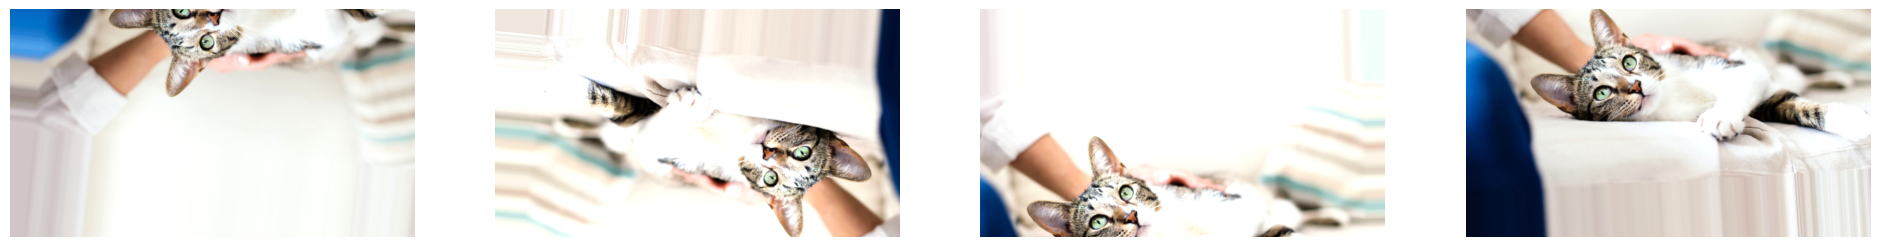

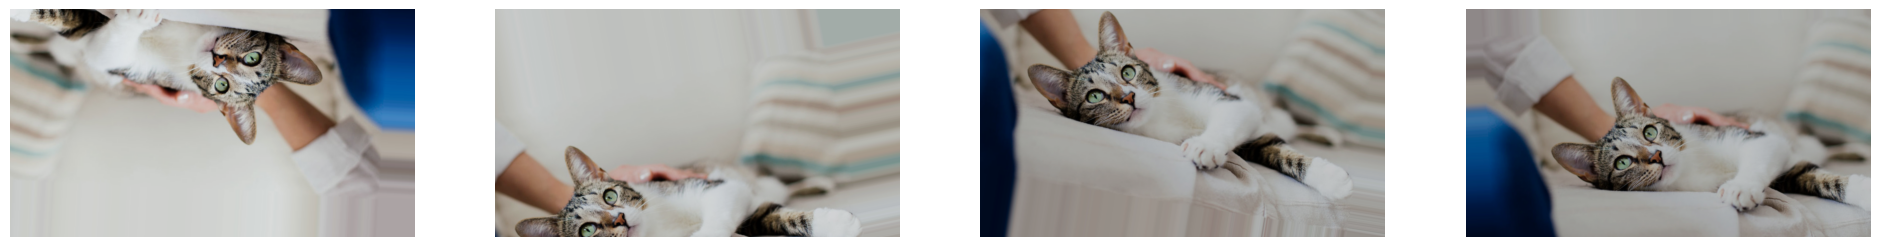

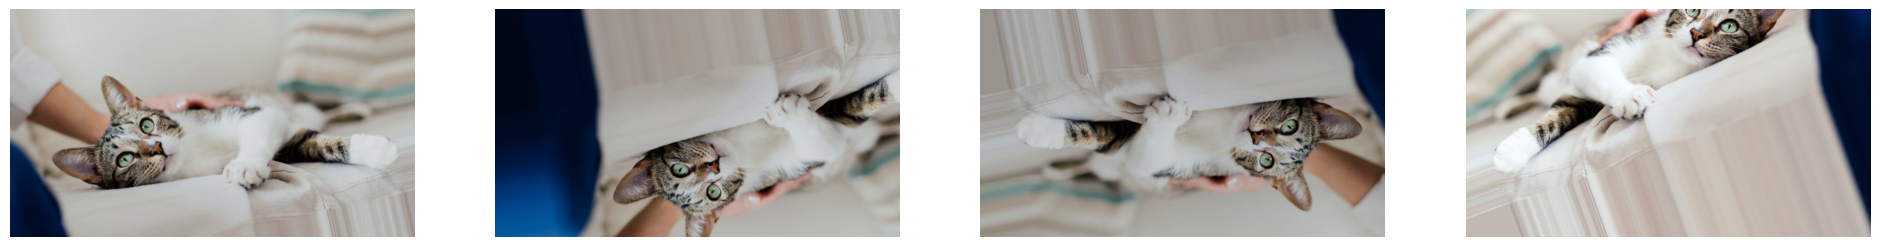

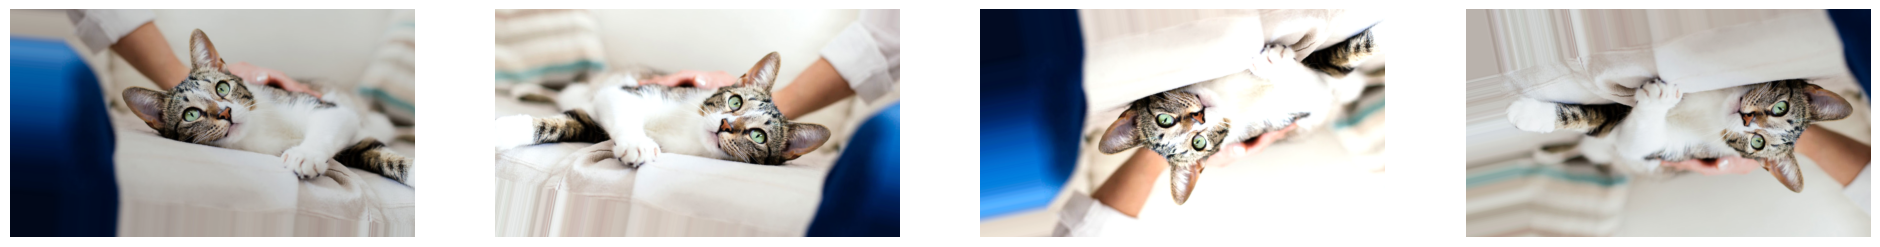

In [11]:
# 일반적으론 아래와 같이 한꺼번에 적용한다.

data_generator = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range = (0.7, 1.3),
    horizontal_flip = True,
    vertical_flip = True
)

for i in range(4):
    show_aug_image_batch(image, data_generator, n_images=4)